<a href="https://colab.research.google.com/github/dustoff06/FERP/blob/main/FERP_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_t, t, kurtosis

def estimate_degrees_of_freedom(data, min_df=2, max_df=30):
    """
    Estimate degrees of freedom from data using kurtosis matching.

    The t-distribution's kurtosis is related to its degrees of freedom by:
    kurt = 6/(df-4) for df > 4
    We'll use this relationship to estimate df from empirical kurtosis.
    """
    # Calculate kurtosis for each column
    k = kurtosis(data, axis=0)

    # Average kurtosis across columns
    k_mean = np.mean(k)

    # Solve for df using relationship between kurtosis and df
    # If kurtosis is too low (< 0), default to high df
    if k_mean <= 0:
        return max_df

    estimated_df = 6/k_mean + 4

    # Bound the estimate
    return np.clip(estimated_df, min_df, max_df)

def nearest_positive_definite(matrix):
    """
    Ensures the given matrix is positive definite by adjusting small eigenvalues.
    """
    eigval, eigvec = np.linalg.eigh(matrix)
    eigval[eigval < 1e-6] = 1e-6  # Adjust near-zero eigenvalues
    return eigvec @ np.diag(eigval) @ eigvec.T

def estimate_covariance(df, epsilon=1e-6):
    """
    Computes the empirical correlation matrix from ranking data.
    Standardizes each ranking column separately.
    """
    # Standardize each column (ranking system) separately
    standardized_rankings = (df - df.mean(axis=0)) / (df.std(axis=0, ddof=1) + epsilon)

    # Compute correlation matrix
    Sigma = np.corrcoef(standardized_rankings.T)

    # Ensure positive definiteness
    Sigma += np.eye(Sigma.shape[0]) * epsilon
    if not np.all(np.linalg.eigvals(Sigma) > 0):
        Sigma = nearest_positive_definite(Sigma)

    return Sigma

def rank_to_uniform(rankings):
    """
    Convert rankings to uniform [0,1] variables using empirical CDF
    """
    n = len(rankings)
    return pd.Series(rankings).rank(method='average') / (n + 1)

def t_copula_monte_carlo(rankings1, rankings2, rankings3, nu=None, num_samples=10000):
    """
    Computes the t-copula joint probability using Monte Carlo approximation and
    returns conditional marginals.

    Parameters:
    - rankings1, rankings2, rankings3: Raw ranking data
    - nu: Degrees of freedom for the t-copula (if None, estimated from data)
    - num_samples: Number of Monte Carlo samples

    Returns:
    - joint_prob: Approximate joint probability from Monte Carlo integration
    - conditional_marginals: Dictionary of conditional probabilities
    """
    # Create DataFrame of rankings
    df_rankings = pd.DataFrame({
        'rank1': rankings1,
        'rank2': rankings2,
        'rank3': rankings3
    })

    # Check for ties
    n_items = len(rankings1)
    if np.any(df_rankings.nunique() < n_items * 0.8):
        print("⚠️ Warning: Some rankings may contain too many ties!")

    # Estimate degrees of freedom if not provided
    if nu is None:
        nu = estimate_degrees_of_freedom(df_rankings.values)
        print(f"Estimated degrees of freedom: {nu:.2f}")

    # Convert rankings to uniform variables using empirical CDF
    U1 = rank_to_uniform(rankings1)
    U2 = rank_to_uniform(rankings2)
    U3 = rank_to_uniform(rankings3)

    # Estimate correlation matrix from ranking data
    Sigma = estimate_covariance(df_rankings)

    # Generate samples from multivariate t-distribution
    t_samples = multivariate_t.rvs(df=nu, shape=Sigma, size=num_samples)

    # Transform t-samples to uniform using t-CDF
    u_samples = t.cdf(t_samples, df=nu)

    # Compute empirical joint CDF
    joint_prob = np.mean(
        (u_samples[:, 0] <= U1.values[:, None]) &
        (u_samples[:, 1] <= U2.values[:, None]) &
        (u_samples[:, 2] <= U3.values[:, None]),
        axis=1
    )

    # Convert uniform variables to t quantiles
    t1 = t.ppf(U1, df=nu)
    t2 = t.ppf(U2, df=nu)
    t3 = t.ppf(U3, df=nu)

    # Compute conditional probabilities
    Sigma_23 = Sigma[1:, 1:]
    Sigma_1_23 = Sigma[0, 1:]
    Sigma_23_inv = np.linalg.inv(Sigma_23)

    # Conditional means and variances in t-space
    cond_mean_1 = Sigma_1_23 @ Sigma_23_inv @ np.vstack([t2, t3])
    cond_var_1 = (Sigma[0, 0] - Sigma_1_23 @ Sigma_23_inv @ Sigma_1_23.T) * (nu + 2) / nu

    cond_mean_2 = Sigma[1, [0, 2]] @ np.linalg.inv(Sigma[np.ix_([0, 2], [0, 2])]) @ np.vstack([t1, t3])
    cond_var_2 = (Sigma[1, 1] - Sigma[1, [0, 2]] @ np.linalg.inv(Sigma[np.ix_([0, 2], [0, 2])]) @ Sigma[[0, 2], 1]) * (nu + 2) / nu

    cond_mean_3 = Sigma[2, :2] @ np.linalg.inv(Sigma[:2, :2]) @ np.vstack([t1, t2])
    cond_var_3 = (Sigma[2, 2] - Sigma[2, :2] @ np.linalg.inv(Sigma[:2, :2]) @ Sigma[:2, 2]) * (nu + 2) / nu

    # Transform back to uniform space for conditional probabilities
    cond_prob_1 = t.cdf(t1, df=nu, loc=cond_mean_1.T, scale=np.sqrt(cond_var_1))
    cond_prob_2 = t.cdf(t2, df=nu, loc=cond_mean_2.T, scale=np.sqrt(cond_var_2))
    cond_prob_3 = t.cdf(t3, df=nu, loc=cond_mean_3.T, scale=np.sqrt(cond_var_3))

    conditional_marginals = {
        "P(U1 | U2, U3)": cond_prob_1.mean(),
        "P(U2 | U1, U3)": cond_prob_2.mean(),
        "P(U3 | U1, U2)": cond_prob_3.mean()
    }

    return joint_prob, conditional_marginals

# Example usage
np.random.seed(42)
n_items = 100

# Generate rankings with some ties
rankings1 = np.random.randint(1, n_items//2, n_items)  # Contains ties
rankings2 = rankings1 + np.random.normal(0, 10, n_items)  # Correlated with rankings1
rankings3 = np.random.permutation(n_items) + 1  # No ties

# Compute joint probability and conditional marginals with adaptive df
joint_prob, conditional_marginals = t_copula_monte_carlo(rankings1, rankings2, rankings3)

print(f"Joint Probability (T-Copula - Monte Carlo): {joint_prob.mean():.6f}")
print("Conditional Marginals:", conditional_marginals)

⚠️ Warning: Some rankings may contain too many ties!
Estimated degrees of freedom: 30.00
Joint Probability (T-Copula - Monte Carlo): 0.185494
Conditional Marginals: {'P(U1 | U2, U3)': 0.4894346545421991, 'P(U2 | U1, U3)': 0.5052494789969144, 'P(U3 | U1, U2)': 0.49829944162025747}


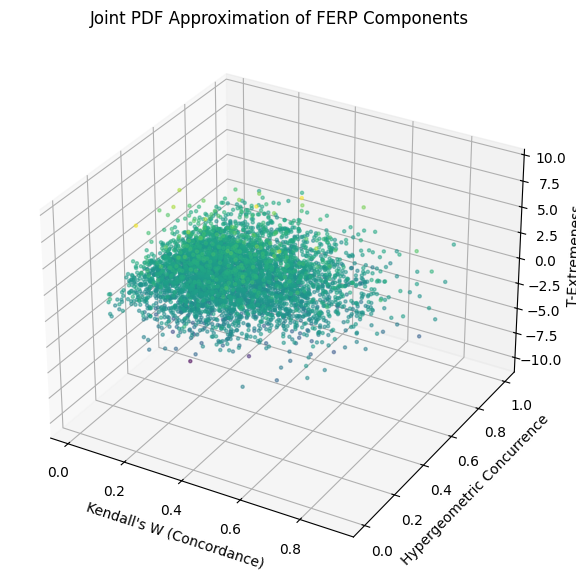

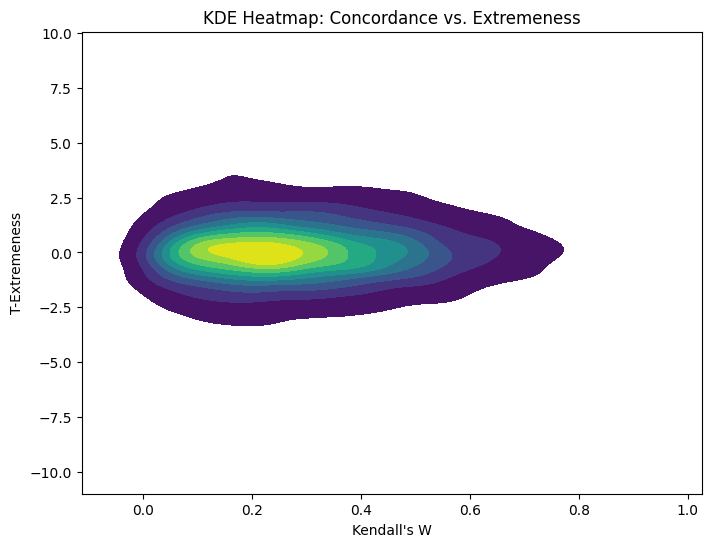

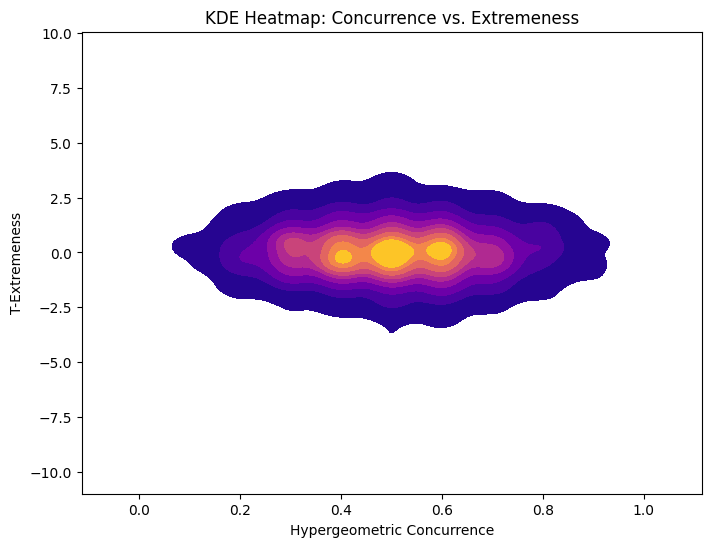

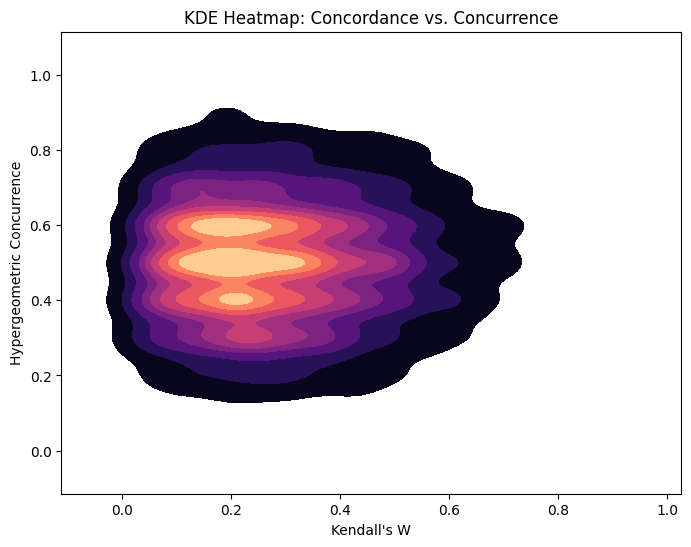

NameError: name 'tools' is not defined

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D




# Generate Monte Carlo samples
N = 5000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a t-distribution (heavier tails)
t_extremeness = np.random.standard_t(df=5, size=N)  # Degrees of freedom = 5

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'T_Extremeness': t_extremeness
})

# Generate 3D Density Plot (Scatter Approximation)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot density representation
ax.scatter(df['Kendall_W'], df['Hypergeometric_Concurrence'], df['T_Extremeness'],
           c=df['T_Extremeness'], cmap='viridis', alpha=0.5, s=5)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("T-Extremeness")
ax.set_title("Joint PDF Approximation of FERP Components")

plt.show()

# Show KDE heatmap for Kendall's W vs. T-Extremeness
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["T_Extremeness"], fill=True, cmap="viridis")
plt.xlabel("Kendall's W")
plt.ylabel("T-Extremeness")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.show()

# Show KDE heatmap for Hypergeometric Concurrence vs. T-Extremeness
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["T_Extremeness"], fill=True, cmap="plasma")
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("T-Extremeness")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.show()

# Show KDE heatmap for Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma")
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.show()

# Display the generated data
print(df.head())
